In [140]:
# Libraries and figure settings
%matplotlib inline

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import matplotlib
plt.style.use('fivethirtyeight')

### TODO: 
- Simplificar nombres CCAA
- Calcular total nacional
- Calcular valores per capita
- Mostrar lineas verticales en las visualizaciones
- Arreglar figura superior

## COVID-19 data analysis

Voy a utilizar el dataset del centro nacional de epidemiologia (se actualiza todos los dias)

In [141]:
req = requests.get("https://covid19.isciii.es/resources/serie_historica_acumulados.csv")
csv = req.content.decode('ISO-8859-1')

filename = 'serie_historica_acumulados.csv'
with open(filename, 'w') as f:
    f.write(csv)

### Obtengo el censo de CCAA de España

Una vez más, los datos los he sacado de https://datos.gob.es/

```
https://datos.gob.es/es/catalogo/ea0010587-poblacion-por-sexo-edad-grupos-quinquenales-y-pais-de-nacimiento-comunidades-autonomas-y-provincias-censos-de-poblacion-y-viviendas-identificador-api-t20-e244-avance-p01-l0-04007-px
```


In [169]:
censo=pd.read_csv('censo_espana_2011.csv', skiprows=5, nrows=63, sep=';', header=[0,1], index_col=0) # a partir de esta fila segregan los datos por pais de origen

censo_total = censo['Ambos sexos'].reset_index()
censo_total['TOTAL'] = censo_total['TOTAL'].apply(lambda x: x.strip()) # elimino espacios innecesarios
censo_total['Total'] = censo_total['Total'].apply(lambda x: int(x.replace('.', '')))

es_ccaa = censo_total.TOTAL == censo_total.TOTAL.apply(lambda x: x.upper()) # las CCAA vienen en todo mayusculas
ceuta_melilla = censo_total.TOTAL.isin(['Ceuta', 'Melilla'])
censo_ccaa = censo_total[es_ccaa | ceuta_melilla].reset_index(drop=True)

censo_ccaa = censo_ccaa.rename(columns={'TOTAL':'CCAA', 'Total':'Poblacion'})

censo_ccaa['CCAA'] = censo_ccaa['CCAA'].apply(lambda x: x.lower().title()) # title es como capitalize() pero para todas las palabras de la cadena
censo_ccaa

# censo_ccaa[censo_ccaa.CCAA != 'Total Nacional'].Poblacion.sum()  # 46815919 check

,CCAA,Poblacion
0,Total Nacional,46815916
1,Andalucía,8371270
2,Aragón,1344509
3,"Asturias, Principado De",1075183
4,"Balears, Illes",1100503
5,Canarias,2082655
6,Cantabria,592542
7,Castilla Y León,2540188
8,Castilla-La Mancha,2106331
9,Cataluña,7519843


In [174]:
nombres_ccaa = {'AN':'Andalucía', 'AR':'Aragón', 'AS':'Asturias, Principado De', 'CB':'Cantabria', 'CE':'Ceuta', 'CL':'Castilla Y León',
                'CM':'Castilla-La Mancha', 'CN':'Navarra, Comunidad Foral De', 'CT':'Cataluña', 'EX':'Extremadura', 'GA':'Galicia',
                'IB':'Balears, Illes', 'MC':'Murcia, Región De', 'MD':'Madrid, Comunidad De', 'ME':'Melilla', 'NC':'Total Nacional',
                'PV':'País Vasco', 'RI':'Rioja, La', 'VC':'Comunitat Valenciana'}

### Parseo los datos de la epidemia

In [225]:
df = pd.read_csv('serie_historica_acumulados.csv', parse_dates=[1], infer_datetime_format=True )
df = df[:-1]  # elimino comentario de la ultima fila
df = df.rename(columns={'CCAA Codigo ISO':'CCAA', 'Casos ':'Casos'})
df = df.fillna(0)
df['CCAA'] = df['CCAA'].apply(lambda x: nombres_ccaa[x])

# Elimino los registros sin casos
df = df[df['Casos'] > 0]

# Calculo los nuevos casos por CCAA
df = df.sort_values(by=['CCAA','Fecha'])
for col in ['Casos', 'Hospitalizados', 'UCI', 'Fallecidos']:
    df['nuevos' + col] = df.groupby('CCAA')[col].diff().fillna(0)

# Dias desde el inicio de la epidemia por CCAA
df['Dias'] = df.groupby('CCAA')['Fecha'].transform(lambda x: x - x.iloc[0]).dt.days  # magia negra

print(df.dtypes)
df.head()

CCAA                            object
Fecha                   datetime64[ns]
Casos                          float64
Hospitalizados                 float64
UCI                            float64
Fallecidos                     float64
nuevosCasos                    float64
nuevosHospitalizados           float64
nuevosUCI                      float64
nuevosFallecidos               float64
Dias                             int64
dtype: object


,CCAA,Fecha,Casos,Hospitalizados,UCI,Fallecidos,nuevosCasos,nuevosHospitalizados,nuevosUCI,nuevosFallecidos,Dias
114,Andalucía,2020-02-26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
133,Andalucía,2020-02-27,6.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1
152,Andalucía,2020-02-28,8.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2
171,Andalucía,2020-02-29,12.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3
190,Andalucía,2020-03-01,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [226]:
# fechas cuarentena (fuente: https://es.wikipedia.org/wiki/Cuarentena_de_Espa%C3%B1a_de_2020 )
inicio_cuarentena_madrid = np.datetime64('2020-03-11') # cierre colegios?
inicio_cuarentena = np.datetime64('2020-03-15')
fase_dos_cuarentena = np.datetime64('2020-03-30')


### Nuevos casos vs Total Casos

# EL TOTAL NACIONAL ESTÁ MAL CALCULADO

In [254]:
df.CCAA.unique()

array(['Andalucía', 'Aragón', 'Asturias, Principado De', 'Balears, Illes',
       'Cantabria', 'Castilla Y León', 'Castilla-La Mancha', 'Cataluña',
       'Ceuta', 'Comunitat Valenciana', 'Extremadura', 'Galicia',
       'Madrid, Comunidad De', 'Melilla', 'Murcia, Región De',
       'Navarra, Comunidad Foral De', 'País Vasco', 'Rioja, La',
       'Total Nacional'], dtype=object)

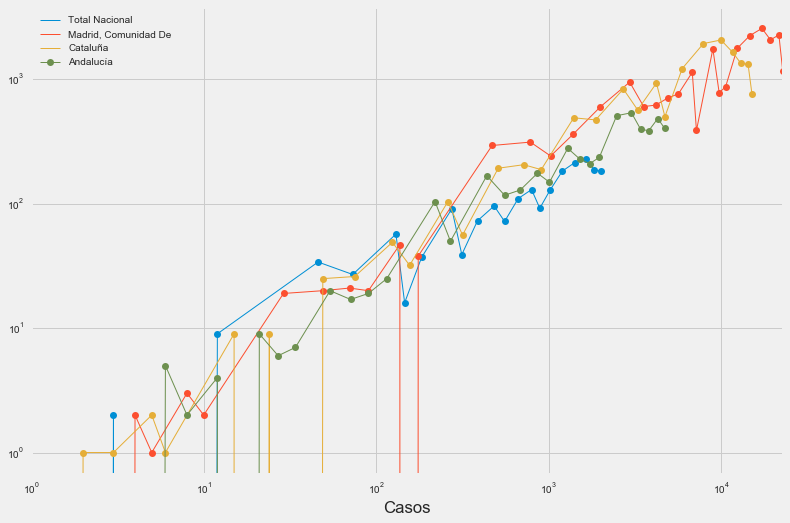

In [259]:
fig, ax = plt.subplots()

selected_ccaa = ['Total Nacional', 'Madrid, Comunidad De', 'Cataluña', 'Andalucía']

for ccaa in selected_ccaa:
    df[df.CCAA == ccaa].plot(x='Casos', y='nuevosCasos', marker='o', lw=1, ax=ax, label=ccaa, loglog=True, figsize=(12, 8))
    

### Algunas visualizaciones para Madrid

Parece que faltan datos de Hospitalizados, UCI y Fallecidos los primeros días

In [223]:
madrid = df[df.CCAA == 'Madrid, Comunidad De']
madrid.head()

,CCAA,Fecha,Casos,Hospitalizados,UCI,Fallecidos,nuevosCasos,nuevosHospitalizados,nuevosUCI,nuevosFallecidos,Dias
108,"Madrid, Comunidad De",2020-02-25,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
127,"Madrid, Comunidad De",2020-02-26,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1
146,"Madrid, Comunidad De",2020-02-27,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
165,"Madrid, Comunidad De",2020-02-28,8.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3
184,"Madrid, Comunidad De",2020-02-29,10.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4


/Users/Manu/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


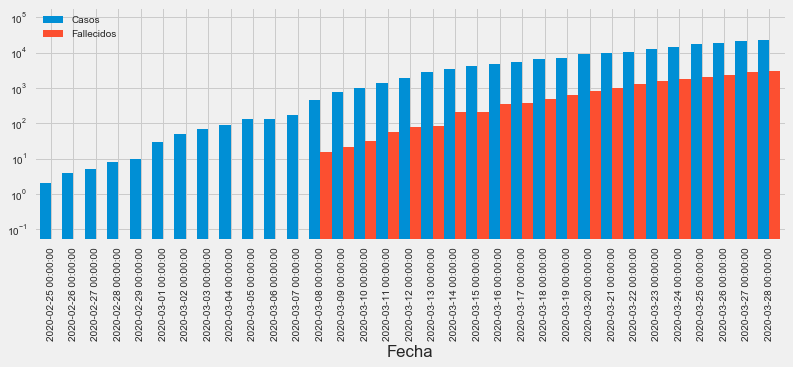

In [246]:
es_madrid = df.CCAA.apply(lambda x: x.find('Madrid') != -1) # otra manera de filtrar por CCAA

fig, ax = plt.subplots()

nuax = df[es_madrid].plot(x='Fecha', y=['Casos', 'Fallecidos'],  #'Hospitalizados','UCI', 
                   kind='bar',  width=1.0, figsize=(12,4), logy=True, ax=ax)

nuax.plot([inicio_cuarentena_madrid]*2, [0.1, 10**5], 'k')
fig.show()
#ax.axvline(x=inicio_cuarentena_madrid, ymin=0.1, ymax=10**5, color='k')
#ax.axvline(pd.to_datetime(inicio_cuarentena_madrid), color='k', linestyle='--', lw=10)


In [242]:
10**5

100000

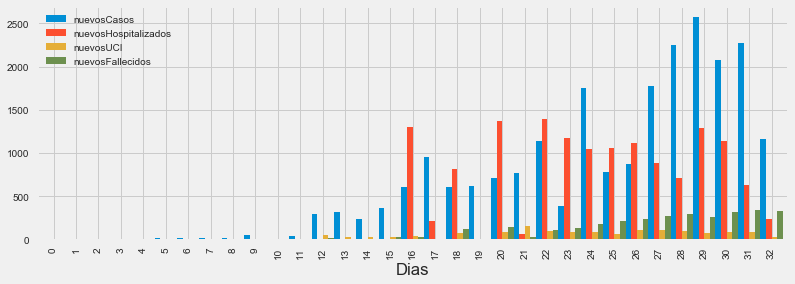

In [224]:
df[es_madrid].plot(x='Dias', y=['nuevosCasos', 'nuevosHospitalizados','nuevosUCI', 'nuevosFallecidos'], 
                   kind='bar',  width=1.0, figsize=(12,4), logy=False, )